In [71]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from pathlib import Path
from imblearn.under_sampling import RandomUnderSampler
import sys
import seaborn as sns
import matplotlib.pyplot as plt


PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

from app.assets import preprocessing 


In [ ]:
data = preprocessing.load_processed_data()
df_customer = data['customer']
df_order = data['order']
df_geo = data['geo']
df_order_item = data['order_item']
df_product = data['product']
df_order_payment = data['order_payment']
df_order_review = data['order_review']
df_seller = data['seller']

In [4]:
DAYS_OF_WEEK = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', "Friday"]

df_order['is_weekday'] = df_order['purchase_timestamp'].dt.day_name().isin(DAYS_OF_WEEK)

In [125]:
order_payment = df_order.merge(df_order_payment)

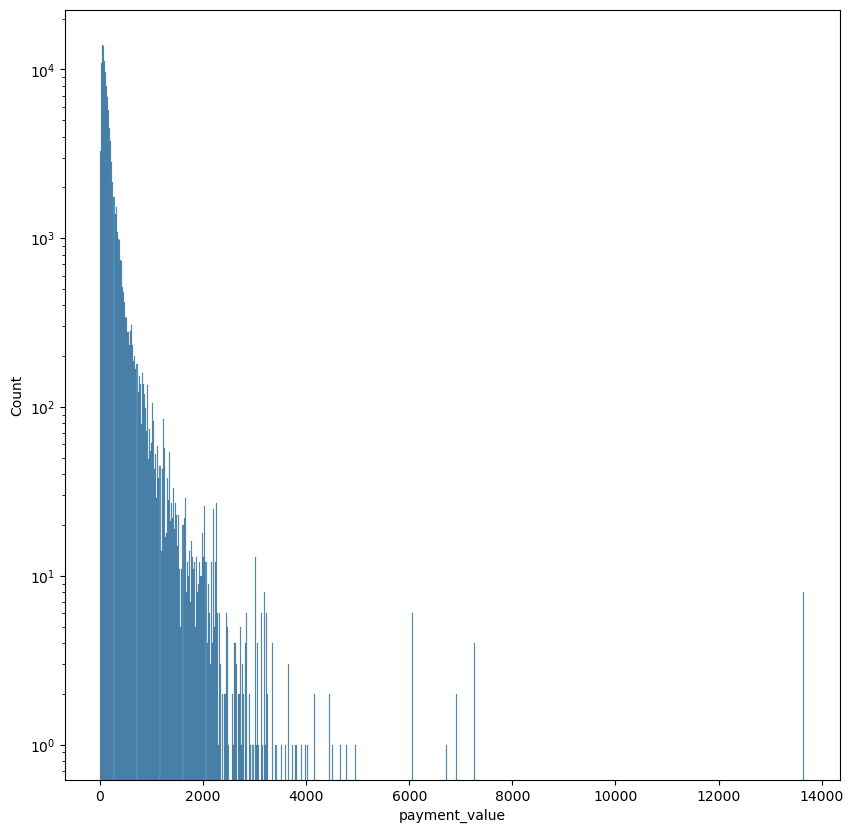

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

sns.histplot(X, x='payment_value',ax=ax, log=True)
%matplotlib inline

In [ ]:
q1 = order_payment['payment_value'].quantile(.25)
q3 = order_payment['payment_value'].quantile(.75)

iqr = q3 - q1

lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

In [ ]:
mask = (order_payment['payment_value'] < upper_bound) & (order_payment['payment_value'] > lower_bound)
order_payment_no_outliers = order_payment[mask]


In [ ]:
X = order_payment_no_outliers['payment_value'].to_frame()
y = order_payment_no_outliers['is_weekday'].to_frame()

In [135]:
rs = RobustScaler()
ss = StandardScaler()
mms = MinMaxScaler()

In [136]:
rs_fit = pd.DataFrame(rs.fit_transform(X))
ss_fit = pd.DataFrame(ss.fit_transform(X))
mms_fit = pd.DataFrame(mms.fit_transform(X))

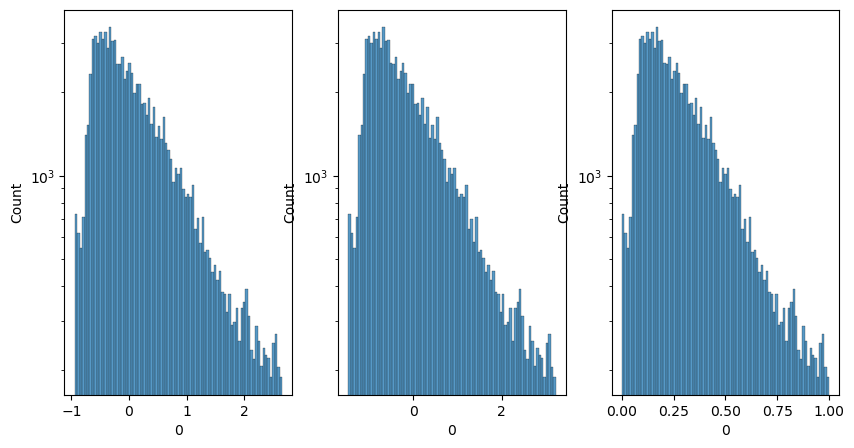

In [137]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

sns.histplot(rs_fit, x=0,ax=ax[0], log=True)

sns.histplot(ss_fit,x=0, ax=ax[1],log=True)
sns.histplot(mms_fit,x=0, ax=ax[2], log=True)
%matplotlib inline

In [141]:
order_payment_no_outliers['payment_value_scaled'] = mms_fit


X = order_payment_no_outliers['payment_value_scaled'].to_frame()
y = order_payment_no_outliers['is_weekday'].to_frame() 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

/var/folders/tk/d53sqng90z98zzrcds69cqbc0000gn/T/ipykernel_64319/1089789901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_payment_no_outliers['payment_value_scaled'] = mms_fit


In [143]:
order_payment_no_outliers.groupby('is_weekday')['payment_value_scaled'].describe()


,count,mean,std,min,25%,50%,75%,max
is_weekday,,,,,,,,
False,21947.0,0.311867,0.211993,0.0,0.149097,0.258445,0.425268,0.999948
True,74326.0,0.313870,0.214202,0.0,0.149516,0.260605,0.428882,1.000000


In [144]:
from collections import Counter

undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X, y)
print("Undersampled class distribution:", Counter(y_under), Counter(X_under))

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.25, random_state=16)

Undersampled class distribution: Counter({'is_weekday': 1}) Counter({'payment_value_scaled': 1})


In [147]:
logreg = LogisticRegression()
logreg.fit(X_under.notna(),y_under)

/opt/anaconda3/envs/olist_env/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [148]:
coefficients = pd.Series(logreg.coef_[0], index=X_train.columns)
print(coefficients)

payment_value_scaled    0.035667
dtype: float64


In [150]:
y_pred = logreg.predict(X_test.notna())

In [151]:
print(classification_report(y_test, y_pred))
result = classification_report(y_test, y_pred)

              precision    recall  f1-score   support

       False       0.53      0.08      0.14      5901
        True       0.51      0.93      0.66      6014

    accuracy                           0.51     11915
   macro avg       0.52      0.51      0.40     11915
weighted avg       0.52      0.51      0.40     11915

